In [8]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Functions we'll use

def fetch_image_data(image_path: str, 
                     show_image: bool = True) -> np.ndarray:
    """
    Reads an image file from the given path using Pillow, and returns it as a NumPy array.
    Optionally, displays the image using Matplotlib.

    Args:
        image_path (str): Path to the image file.
        show_image (bool): Whether to display the image using Matplotlib. Default is True.

    Returns:
        np.ndarray: A NumPy array representing the image.

    Raises:
        FileNotFoundError: If the specified image file does not exist.
        ValueError: If the specified image file is not a valid image file or could not be read.

    """

    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"{image_path} not found")
    try:
        with Image.open(image_path) as image:
            example_image = plt.imread(image_path)
            if show_image:
                plt.figure()
                plt.imshow(example_image)
                plt.title('Image display of: ' + image_path)
            return example_image
    except Exception as e:
        raise ValueError(f"Could not read {image_path}: {str(e)}")


swir wavelengths are shaped: (640,)
vnir wavelengths are shaped: (640,)
Overlap begins at 1550.0nm and ends at 1650.0nm


Text(0, 0.5, 'Raw image values')

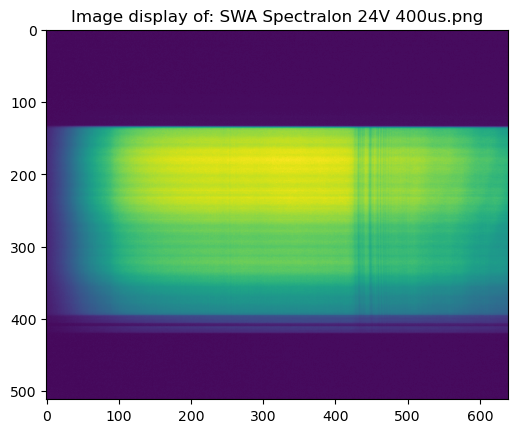

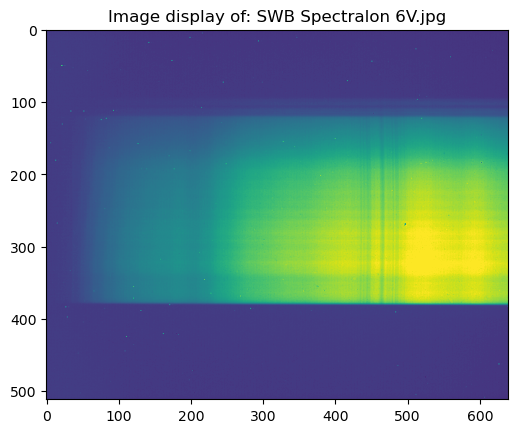

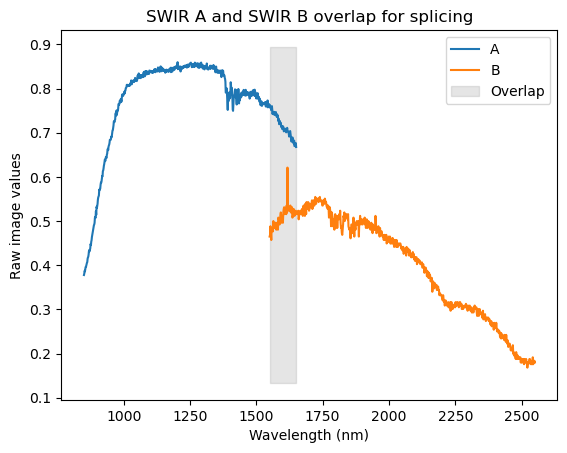

In [4]:
swir_A = fetch_image_data('SWA Spectralon 24V 400us.png')
swir_B = fetch_image_data('SWB Spectralon 6V.jpg')

pixel_to_select = 150

# Info from Mike
# SWIR A (850 to 1650nm) and SWIR B (1550 to 2550nm)
# SWIR A is 850nm on the Left and 1650 on the right
# SWIR B is 2550 on the left and 1550nm on the right. 

swir_wavelengths = [850, 1650]
vnir_wavelengths = [1550, 2550]

wavelengths_A = np.linspace(swir_wavelengths[0], 
                            swir_wavelengths[1], 
                            swir_A.shape[1])
wavelengths_B = np.linspace(vnir_wavelengths[0], 
                            vnir_wavelengths[1], 
                            swir_B.shape[1])

print(f"swir wavelengths are shaped: {wavelengths_A.shape}")
print(f"vnir wavelengths are shaped: {wavelengths_B.shape}")


pixel_A = swir_A[pixel_to_select, :]
# B data is scaled to 256, A is scaled between 0 and 1, fix this
pixel_B = np.flip(swir_B[pixel_to_select, :] / 256)

# Plot the current data and where they overlap
plt.figure()
plt.plot(wavelengths_A, pixel_A)
plt.plot(wavelengths_B, pixel_B)

# Find the overlap region
overlap_start = max(min(wavelengths_A), min(wavelengths_B))
overlap_end = min(max(wavelengths_A), max(wavelengths_B))

print(f"Overlap begins at {overlap_start}nm and ends at {overlap_end}nm")

# Add a shaded region to show the overlap
plt.fill_between([overlap_start,
                  overlap_end],
                 plt.ylim()[0],
                 plt.ylim()[1],
                 color='gray',
                 alpha=0.2)

# Add a legend to the plot
plt.legend(['A', 'B', 'Overlap'])
plt.title('SWIR A and SWIR B overlap for splicing')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Raw image values')

vnir data is shaped: (200, 640)
swir data is shaped: (200, 640)


Text(0, 0.5, 'Raw image values')

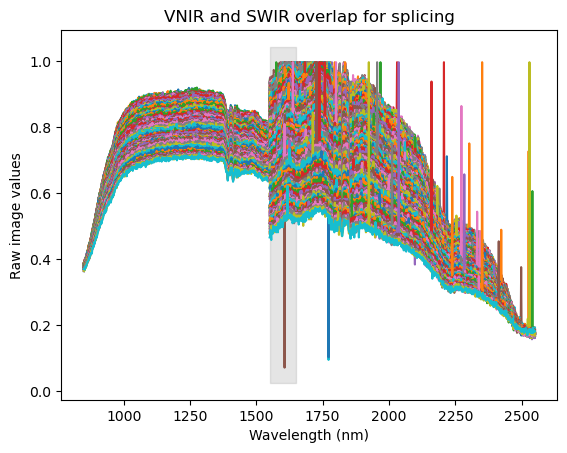

In [5]:
# We need at least a batch of pixels and not a single pixel to do 
# many of the corrections we want to do

# Set a number of pixels
n_pixels = 200

# subset our data
vnir = swir_A[pixel_to_select:pixel_to_select+n_pixels, :]
# Subset *and* correct this data - it needs to be flipped and normalized to the same range
swir = np.flip(swir_B[pixel_to_select:pixel_to_select+n_pixels, :]/256)

print(f"vnir data is shaped: {vnir.shape}")
print(f"swir data is shaped: {swir.shape}")

# Plot the current data and where they overlap
plt.figure()
plt.plot(wavelengths_A, vnir.T)
plt.plot(wavelengths_B, swir.T)

# Add a shaded region to show the overlap
plt.fill_between([overlap_start, overlap_end], plt.ylim()[0], plt.ylim()[1], color='gray', alpha=0.2)

# Add a legend to the plot
plt.title('VNIR and SWIR overlap for splicing')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Raw image values')

In [7]:
# Let's identify V and S primes, i.e. the overlapping data region

v_prime = vnir[:, wavelengths_A >= overlap_start]
s_prime = swir[:, wavelengths_B <= overlap_end]

print(f"V' size': {v_prime.shape}")
print(f"S' size': {s_prime.shape}")

# And make a few values for later concatenating the final batch of data
# These are the values and wavelengths that are outside of the overlap region
initial_vnir_vals = vnir[:, wavelengths_A < overlap_start]
initial_vnir_wavs = wavelengths_A[wavelengths_A < overlap_start]
initial_swir_vals = vnir[:, wavelengths_B > overlap_end]
initial_swir_wavs = wavelengths_B[wavelengths_B > overlap_end]

print(f"VNIR: init dims {initial_vnir_vals.shape}, wavelengths: {initial_vnir_wavs.shape}")
print(f"SWIR: init dims {initial_swir_vals.shape}, wavelengths: {initial_swir_wavs.shape}")

V' size': (200, 80)
S' size': (200, 64)
VNIR: init dims (200, 560), wavelengths: (560,)
SWIR: init dims (200, 576), wavelengths: (576,)


In [11]:
# determine the new length - note here that we prefer to downsample
# to the smallest value based on the 2021 paper by the same author,
# as it hopes to help avoid upsampling artifacts
new_length = min(v_prime.shape[1], s_prime.shape[1])

# Define the wavelengths in the overlapping range Λ'
lambda_min = max(np.min(wavelengths_A), np.min(wavelengths_B))
lambda_max = min(np.max(wavelengths_A), np.max(wavelengths_B))
lambda_overlap = np.linspace(lambda_min, lambda_max+1, num = new_length)

v_prime_interp = np.empty((v_prime.shape[0], new_length))
s_prime_interp = np.empty((v_prime.shape[0], new_length))

# interpolate v_prime to the new length
for i in range(v_prime.shape[0]):
    v_prime_interp[i,:] = np.interp(np.linspace(0, len(v_prime) - 1, new_length),
                            np.arange(len(v_prime[i,:])), v_prime[i,:])

    # interpolate s_prime to the new length
    s_prime_interp[i,:] = np.interp(np.linspace(0, len(s_prime) - 1, new_length),
                            np.arange(len(s_prime[i,:])), s_prime[i,:])

# Calculate the distance ∆r between V' and S'
dr = np.sqrt(np.mean((v_prime_interp - s_prime_interp)**2, axis=1))

# Define the parameters for the logistic function for the correcting coefficients
L = np.max([np.abs(v_prime_interp - 1), np.abs(s_prime_interp - 1)], axis=0)
k = 20/np.max(dr)
x0 = np.median(dr)

print(f"v_prime_interp is shaped: {v_prime_interp.shape}")
print(f"dr Shape: {dr.shape}, L Shape: {L.shape}, k: {k}, x0: {x0}")

v_prime_interp is shaped: (200, 64)
dr Shape: (200,), L Shape: (200, 64), k: 72.84840085153057, x0: 0.18544712061741742


In [48]:
# Define the logistic function for the window width
def logistic_function(x, cv, x0v, N_vnir):
    return N_vnir / (1 + np.exp(-cv * (x - x0v)))

# Define N''v as the length of the non-overlapping region
N_vnir = initial_vnir_wavs.shape[0]

# Fit the logistic function to the data
popt, pcov = curve_fit(logistic_function, dr, N_vnir/(1+np.exp(-cv*(dr-x0v))), p0=[1, 1, N_vnir], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))

# Retrieve the values of cv and x0v
cv_fit, x0v_fit, N_vnir_fit = popt


NameError: name 'cv' is not defined

In [46]:
# Define the logistic function
# Fix this to not fit the N value that we have, in this case "new_length"
print(f"Use {new_length} as the value in this function")
def logistic(x, c, x0):
    return 64 / (1 + np.exp(-c*(x-x0)))

N_vnir = v_prime_interp.shape[1]
N_swir = s_prime_interp.shape[1]

# Define the logarithmically spaced values of dr
log_dr = np.log10(dr)

# Define the initial guesses for the logistic function parameters
N_guess = np.max([N_vnir, N_swir])
c_guess = 1
x0_guess = np.median(dr)

# Fit the logistic function to the data
params_vnir, _ = curve_fit(logistic,
                           log_dr,
                           new_length,
                           p0=[c_guess, x0_guess])
params_swir, _ = curve_fit(logistic,
                           log_dr,
                           new_length*0.5,
                           p0=[c_guess, x0_guess])

# Extract the learned parameters
cv_fit, x0v_fit = params_vnir
cs_fit, x0s_fit = params_swir

print(cv_fit, x0v_fit)
print(cs_fit, x0s_fit)

# Now let's get the actual wv and ws:
ws = round(logistic(dr[0], cv_fit, x0v_fit))
wv = round(logistic(dr[0], cs_fit, x0s_fit))
print(f"Spectral window adjustment width for swir is: {ws}")
print(f"Spectral window adjustment width for vnir is: {wv}")



Use 64 as the value in this function
-1.1175322650999389 22.47478165591213
2.2311316801956666e-09 -0.11037487240235795
Spectral window adjustment width for swir is: 64
Spectral window adjustment width for vnir is: 32
